In [1]:
import numpy
import h5py
import pandas

from toposample import Config, data
from figure_helper import FigureHelper
from pandas_helper import column_names_to_values
from toposample.db import get_column_from_database
from toposample.data import read_h5_dataset

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir_mn_sz50/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
# Which parameters to plot and in which order. We determined them in the Fig 3 notebook
spec_parameters = ['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']
# Parameters related to tribe sizes.
spec_size_related = ['Tribe size', 'Mean size']

fig_4a_bar_params = {"color": "grey"}
fig_4a_plot_params = {"marker": '.', "ms": 1.,
                      "color": 'blue', "ls": 'None'}
fig_4a_err_params = {"ls": 'None', "color": 'black',
                     "elinewidth": 3, "capsize": 5}
fig_4b_ss_params = {"color": [0.75, 0.4, 0.4], "marker": "o",
                    "ms": 4.5, "ls": ":"}
fig_4b_plot_params = {"ls": "None", "marker": "d",
                      "ms": 7, "color": 'grey'}
fig_4b_err_params = {"lw": 0.5, "color": 'black'}
fig_4b_idv_params = {"ls": "None", "marker": '.',
                     "ms": 1, "color": 'blue'}
fig_s9_plot_params = {"marker": '.', "ms": 2,
                      "color": 'blue', "ls": 'None'}
fig_s9_bar_params = {"color": 'grey'}
fig_s9_err_params = {"ls": 'None', "color": 'black',
                     "elinewidth": 3, "capsize": 5}
fig_s10_plot_params = {"marker": '.', "ms": 2,
                      "ls": 'None', "color": 'grey'}
fig_s10_fit_params = {"ls": '--', "color": 'black'}
fig_4d_bar_params = {"color": 'gray', "width": 0.8}
"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 4")
S9 = fhlpr("Figure S9")
S10 = fhlpr("Figure S10")

In [2]:
"""
Files we are going to load
"""
tribe_struc_params_fn = cfg._cfg['analyzed']['struc_parameters']
tribe_gids_fn = cfg._cfg['analyzed']['tribes']
db_fn = cfg._cfg['analyzed']['database']
tribe_accuracy_fn = cfg._cfg['analyzed']['classifier_components_results']

"""
Load the data
"""
acc_reader = read_h5_dataset("scores")  # Loading function to extract the accuracy

# Values of the topological parameters for all neuron samples
tribe_struc_params = data.TopoData(tribe_struc_params_fn)

# The identifiers of neurons in all neuron samples.
# Used to determine sample sizes and mean values of topol. parameters.
tribe_gids = data.TopoData(tribe_gids_fn)['gids']

# The "database" with topological and functional parameters for all neurons in the model
db = pandas.read_pickle(db_fn)

# Finally, the classification accuracies for all neuron samples
data_acc = data.TopoData(tribe_accuracy_fn, follow_link_functions={"data_fn": (acc_reader, True)})['data_fn']

In [3]:
"""
Some analysis of the data
"""
# The mean accuracy of a sample over the 5-times cross-validation
tribe_nonpooled_mean_acc = data_acc.map(numpy.nanmean)

# All individual accuracies for a given type of sample (e.g. champion of euler characteristic)
tribe_pooled_acc = data_acc.pool(["index"], func=numpy.hstack)
# And the mean value thereof
tribe_mean_acc = tribe_pooled_acc.map(numpy.nanmean)
# As well as the standard deviation
tribe_sd_acc = tribe_pooled_acc.map(numpy.nanstd)

#  We sort the order of topological parameters to use by their accuracy in the manifold task
idxx = numpy.argsort([tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                      for spec in spec_parameters])
spec_parameters = [spec_parameters[i] for i in idxx]

# The sizes of all neuron samples
tribe_size = tribe_gids.map(len)
# Average for a given type of sample
tribe_mean_size = tribe_size.pool(["index"], func=numpy.mean)
# Add the size of the samples to the data structure holding the other topological and functional parameters
tribe_struc_params.data["Tribe size"] = tribe_size

# Above, we calculated the size of each neuron sample, tribal or volumetric. Now we go one step further:
# For each sample look up the contained neurons, calculate the sizes of their associated tribes and take the mean.
# I.e. the mean size of tribes whose chief is contained in the sample. This gives a measure of the average
# connectedness of the neuron sample.
all_lengths = db["tribe"].apply(len) # Look up tribe size for _all_ tribes in the db
tribe_struc_params.data["Mean size"] =\
tribe_gids.map(lambda x: numpy.mean(all_lengths.loc[x])) # And calculate mean size of contained neurons


#  Helper function: For a given parameter find all its "subsampled" versions and return them in order
def find_subsampled(base_parameter, data_struc=None):
    if data_struc is None:
        data_struc = data_acc
    subs_specs = data_struc.filter(sampling="subsampled").labels_of("specifier")
    ret_x = []
    ret_specs = []
    for spec in subs_specs:
        spec_name, spec_val = spec.split("@")
        if spec_name != base_parameter:
            continue
        ret_x.append(int(spec_val))
        ret_specs.append(spec)
    idxx = numpy.argsort(ret_x)
    return [ret_x[i] for i in idxx], [ret_specs[i] for i in idxx]


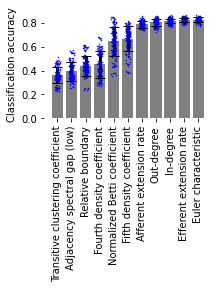

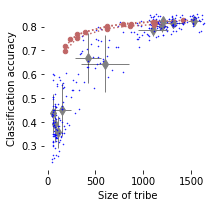

In [4]:
"""
Figure panel: Accuracies for the champions of the various parameters
"""
from matplotlib import pyplot as plt

plot_mean_acc = [tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                for spec in spec_parameters]
plot_sd_acc = [tribe_sd_acc.get2(sampling="Parameter", specifier=spec)
               for spec in spec_parameters]

fig = plt.figure(figsize=(3, 2))
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, **fig_4a_bar_params)
for x, spec in enumerate(spec_parameters):
    y = tribe_pooled_acc.get2(sampling="Parameter", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, **fig_4a_plot_params)
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc, **fig_4a_err_params)
ax.set_xticks(range(len(spec_parameters)))
_ = ax.set_xticklabels(spec_parameters, rotation='vertical')
ax.set_ylabel("Classification accuracy")
plt.box(False)
F.save(fig, fn="Panel-A")

"""
Figure panel: Accuracies vs. sizes of the tribes
"""
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

for spec in spec_parameters:
    index, x = tribe_size.get_x_y("index", sampling="Parameter", specifier=spec)
    mean_x = tribe_mean_size.get2(sampling="Parameter", specifier=spec)
    y = [tribe_nonpooled_mean_acc.get2(sampling="Parameter", specifier=spec, index=idx) for idx in index]
    mean_y = tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
    
    _, subs_spec = find_subsampled(spec)
    if len(subs_spec):
        subs_x = [tribe_mean_size.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        subs_y = [tribe_mean_acc.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        ax.plot(subs_x + [mean_x], subs_y + [mean_y], **fig_4b_ss_params)

    ax.plot(mean_x, mean_y, **fig_4b_plot_params)
    ax.errorbar(mean_x, mean_y, xerr=numpy.std(x), yerr=numpy.std(y), **fig_4b_err_params)
    ax.plot(x, y, **fig_4b_idv_params)
    ax.set_xlabel("Size of tribe")
    ax.set_ylabel("Classification accuracy")
plt.box(False)
F.save(fig, fn="Panel-B")

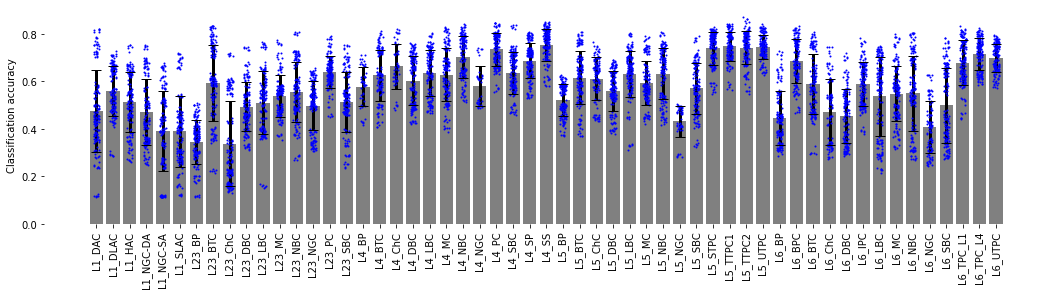

In [5]:
"""
Figure panel: Accuracies for the randomly sampled tribes
"""
# Names of the randomly picked morphological types.
mtype_names = tribe_mean_acc.filter(sampling="M-type").labels_of("specifier")
# Look up mean and sd accuracies for those samples.
plot_mean_acc = [tribe_mean_acc.get2(sampling="M-type", specifier=spec)
                for spec in mtype_names]
plot_sd_acc = [tribe_sd_acc.get2(sampling="M-type", specifier=spec)
               for spec in mtype_names]

fig = plt.figure(figsize=(18, 4))
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, **fig_s9_bar_params)
for x, spec in enumerate(mtype_names):
    y = tribe_pooled_acc.get2(sampling="M-type", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, **fig_s9_plot_params)
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc, **fig_s9_err_params)
    
ax.set_xticks(range(len(mtype_names)))
_ = ax.set_xticklabels(mtype_names, rotation='vertical')
ax.set_ylabel("Classification accuracy")
plt.box(False)

S9.save(fig, fn="Panel-A")

In [7]:
from pandas_helper import assemble_result_dataframe, sanitize_param_name
from helper_functions import analyze_linear_fit
from statsmodels.formula.api import ols

"""
We do some more analysis here. Some of the functions we use require data in the form a pandas.Dataframes.
We have a helper function that assembles the data accordingly. Let's build those dataframes!
"""
# Accuracies, topological parameters and tribe-size related data for the randomly picked tribes
dframe_random_tribes =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, # Accuracy data
                          tribe_struc_params, # Structural and coupling-related data
                          sampling="M-type", # Which type of sample to look up
                          parameters_to_add=spec_parameters + spec_size_related, # Which parameters to add
                          normalize=spec_parameters)
# Accuracies, and tribe-size related data for "champion" samples
dframe_champions =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="Parameter",
                          parameters_to_add=spec_size_related,
                          normalize=[])


# To provide an example of what we got from this
display(dframe_random_tribes)

"""
Now analyze. First, we fit a linear fit of mean tribe size against accuracy using the random samples.
(Note: below we plot one against the other to show that linear fit makes sense. Also see the p-value)
"""
model_size = ols("Accuracy ~ Mean_size", data=dframe_random_tribes).fit()
print(model_size.pvalues["Mean_size"])

"""
Add the residuals to the dataframes. For the dataframe we fit the model on we can directly look it up.
For the volumetric data, we instead subtract the prediction
"""
dframe_random_tribes["Accuracy_residual"] = model_size.resid.values

residual_data_tribes = analyze_linear_fit(dframe_random_tribes, spec_parameters,
                                          column_y="Accuracy_residual")

,specifier,Accuracy,Transitive_clustering_coefficient,Adjacency_spectral_gap_low,Relative_boundary,Fourth_density_coefficient,Normalized_Betti_coefficient,Fifth_density_coefficient,Afferent_extension_rate,Outdegree,Indegree,Efferent_extension_rate,Euler_characteristic,Tribe_size,Mean_size
0,L1_DAC,0.814609,-1.019943,-0.252788,-0.737066,-0.038811,-1.009820,-0.129825,0.852975,3.309480,-0.423313,1.532644,-0.076908,729,625.223594
1,L1_DAC,0.722191,-1.055798,-0.253501,-0.638936,-0.251742,-1.129741,-0.129825,0.477624,2.143214,-0.798350,1.180077,-0.315000,509,528.222004
2,L1_DAC,0.468113,-0.470174,-0.251363,0.361035,-0.674180,-1.334644,-0.129825,-1.024388,-0.456872,-0.884897,-0.813130,-0.456893,120,476.458333
3,L1_DAC,0.118094,-1.229094,6.871672,3.506598,-0.674180,-0.129774,-0.129825,-2.428363,-1.156631,-0.899322,-2.477140,-0.450881,16,355.437500
4,L1_DAC,0.310716,-2.113506,3.127806,5.427151,-0.674180,0.581250,-0.129825,-2.241910,-1.136050,-0.899322,-2.262295,-0.452083,19,461.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,L6_UTPC,0.649889,-0.482125,-0.249225,-0.821466,1.431859,1.535892,-0.129825,1.196715,1.299387,1.047987,0.884101,0.992101,629,574.607313
1272,L6_UTPC,0.606971,-0.255047,-0.252076,-0.743694,1.741311,1.737963,-0.129825,1.036221,-0.216758,1.372539,0.695464,0.477437,459,555.010893
1273,L6_UTPC,0.641546,-0.195289,-0.078200,-0.911345,2.095311,0.781432,1.992361,1.301471,0.805439,1.855760,0.839696,1.589735,677,581.997046
1274,L6_UTPC,0.770300,-0.535907,-0.247800,-0.996167,2.213894,1.732297,1.318713,1.693313,2.513675,3.428032,1.223313,5.055296,1122,634.286096


7.596047276294303e-142


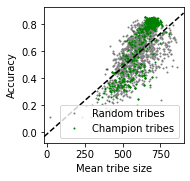

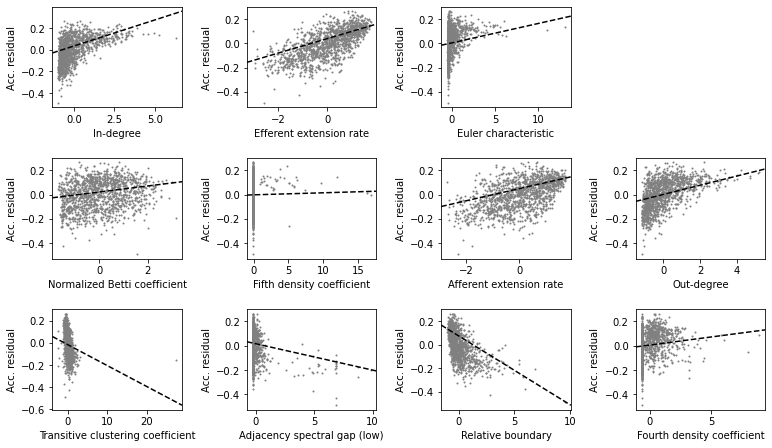

/home/reimann/venvs/topological_sampling/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


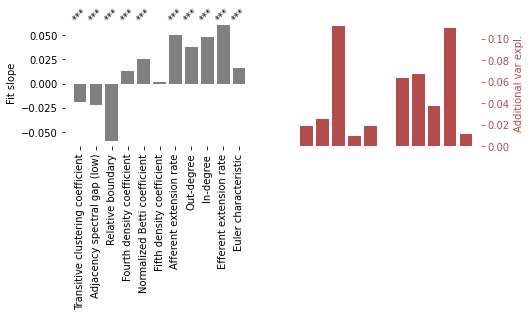

In [16]:
"""
Figure panel: Mean tribe size against accuracy for the "random" tribes and "champions"
"""

fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.gca()
ax.plot(dframe_random_tribes["Mean_size"], dframe_random_tribes["Accuracy"],
        label="Random tribes", **fig_s10_plot_params)
tmp_plot_params = fig_s10_plot_params.copy(); tmp_plot_params["color"] = "green"
ax.plot(dframe_champions["Mean_size"], dframe_champions["Accuracy"],
        label="Champion tribes", **tmp_plot_params)
xx = ax.get_xlim()
ax.set_xlim(xx)
ax.plot(xx, model_size.params["Intercept"] + model_size.params["Mean_size"] * numpy.array(xx),
        **fig_s10_fit_params)
ax.set_xlabel("Mean tribe size")
ax.set_ylabel("Accuracy")
plt.legend()
F.save(fig, fn="Panel-C")

"""
Figure panel: Various topol. parameters against residual accuracy
"""
fig = plt.figure(figsize=(12, 7))
N = len(residual_data_tribes)
X = 4
i = 0
for col, residual_result in residual_data_tribes.items():
    model = residual_result["model"]
    col_san = sanitize_param_name(col)
    
    pos_x = numpy.mod(i, X); pos_y = numpy.floor(i / X)
    i += 1
    
    ax = fig.add_axes([0.05 + pos_x * 0.225, 0.05 + pos_y * 0.3, 0.15, 0.2])
    ax.plot(dframe_random_tribes[col_san],
            dframe_random_tribes["Accuracy_residual"], **fig_s10_plot_params)
    
    xx = ax.get_xlim(); ax.set_xlim(xx)
    ax.plot(xx, model.params["Intercept"] + model.params[col_san] * numpy.array(xx), **fig_s10_fit_params)
    ax.set_xlabel(col)
    ax.set_ylabel("Acc. residual")

S10.save(fig, fn="Panel-A") # Also, pick one of the subpanels as 4D

"""
Figure panel: pearsonr values of the fits for the various parameters
"""
from plot_helpers import plot_linear_fit_results
plot_linear_fit_results(residual_data_tribes, bar_col='grey', var_col=[0.7, 0.3, 0.3])
F.save(plt.gcf(), fn="Panel-E")